# An exercise in generating a boundary 

Here we generate a closed boundary curve from a mask of zeros and ones indicating whether there is data.

In [6]:
using Plots, Slepians
using FastGaussQuadrature, DelimitedFiles, Random
using KernelMatrices, KrylovKit, IterTools, FFTW
Random.seed!(123)


MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state(Int32[1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000

recover the donut boundary

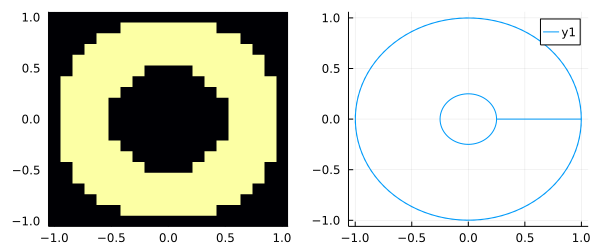

In [2]:
t1 = t2 = LinRange(-1, 1, 20)

mask = broadcast(+, t1'.^2, t2.^2) .< 1.0
mask .-= broadcast(+, t1'.^2, t2.^2) .< 0.5^2

p1 = heatmap(t1, t2, mask, colorbar = false)

t = 2*LinRange(-pi, pi, 100)
x = vcat(cos.(t), 0.5^2*cos.(t[end:-1:1]))
y = vcat(sin.(t), 0.5^2*sin.(t[end:-1:1]))


p2 = plot(x,y)

plot(p1, p2, size = (600, 250))


In [3]:
# Generate the closed curve approximation

xs, ys = getbdypts_2d(Float64.(mask))
xpath, ypath = closedcurve_2d(xs, ys);

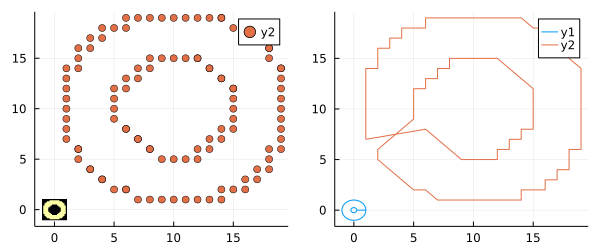

In [4]:
scatter!(p1, xs, ys) 
plot!(p2, xpath, ypath)

plot(p1, p2, size = (600, 250))

# Do the Quadrature

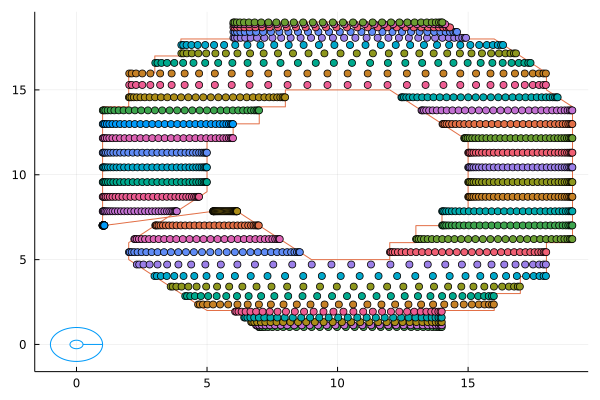

In [8]:
QX, QY, w, Nrun = get_quadrature_nodes_2D(xpath, ypath)
scatter!(p2, QX, QY, legend = false)

# Step 2

For fun, integrate

In [9]:
M  = 3
Kp = [4.0]
szs = int = (16, 16)
prec = 1e-8
exact = false
lvl = 6
maxrank = 256

no    = map(i->(QX[i], QY[i]), 1:prod(size(QX)))
sqwt = sqrt.(w[:]);

ev = vec(collect(product([range(minimum(QX), maximum(QX), length = szs[1]), range(minimum(QY), maximum(QY), length = szs[2]) ]...)))

s, sl = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = no,
        sqwt = sqwt, int = nothing, ev = ev);

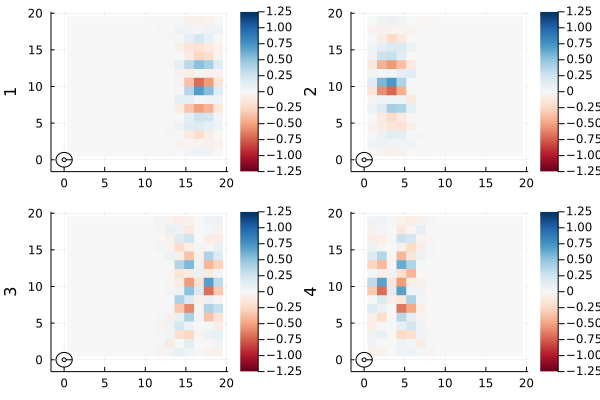

In [10]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ran = 1:4
for i = ran
    p1[i] = heatmap(range(minimum(QX), maximum(QX), length = szs[1]), 
         range(minimum(QY), maximum(QY), length = szs[2]), Float64.(sl[i])',
        c = :RdBu, clims = (-1.25, 1.25), ylabel = i) # this transpose is important
    plot!(p1[i], x, y, legend = false, c = :black)

    SL = abs2.(fftshift(fft(sl[i])))
    p2[i] = heatmap(log10.(SL), ylabel = i)
end

plot(p1[ran]...)

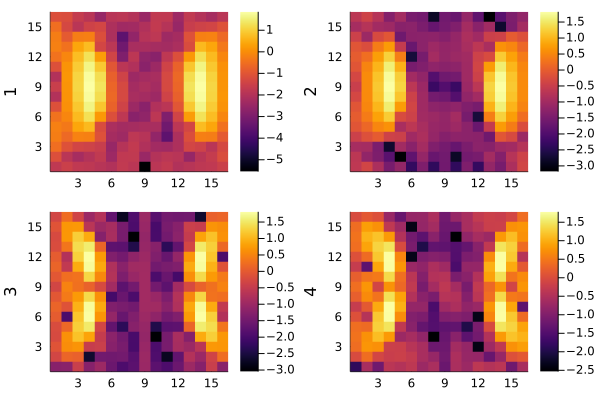

In [11]:
plot(p2[ran]...)